In [1]:
# Cell 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import shap

In [2]:
# Cell 2: Load Data
file_path = "./Cairo-Weather.csv"
df = pd.read_csv(file_path)

print("Shape before cleaning:", df.shape)
df.head()

Shape before cleaning: (5845, 32)


,time,temperature_2m_mean (°C),rain_sum (mm),wind_speed_10m_max (km/h),apparent_temperature_mean (°C),temperature_2m_min (°C),temperature_2m_max (°C),apparent_temperature_max (°C),weather_code (wmo code),wind_direction_10m_dominant (°),...,dew_point_2m_mean (°C),relative_humidity_2m_mean (%),visibility_mean (undefined),visibility_max (undefined),visibility_min (undefined),wind_gusts_10m_mean (km/h),wind_speed_10m_mean (km/h),winddirection_10m_dominant (°),wind_gusts_10m_min (km/h),wind_speed_10m_min (km/h)
0,2/1/2009,14.1,0.0,12.0,11.0,7.9,20.6,17.5,0,215,...,0.7,42,NaN,NaN,NaN,17.1,8.8,215,10.8,5.7
1,2/2/2009,14.3,0.0,11.9,11.4,5.8,21.9,19.1,0,74,...,1.1,45,NaN,NaN,NaN,15.1,7.5,74,7.9,1.1
2,2/3/2009,16.1,0.0,21.3,12.3,9.2,24.0,19.5,2,65,...,2.4,43,NaN,NaN,NaN,27.8,15.0,65,17.3,9.0
3,2/4/2009,17.9,0.0,18.3,15.5,10.9,26.8,24.4,3,90,...,4.0,46,NaN,NaN,NaN,18.9,8.8,90,9.7,0.4
4,2/5/2009,18.0,0.0,13.6,14.4,11.4,26.4,22.2,0,222,...,-1.6,31,NaN,NaN,NaN,19.9,10.0,222,11.9,6.5


In [3]:
# Cell 3: Data Cleaning
df = df.drop(columns=[
    "visibility_mean (undefined)",
    "visibility_max (undefined)",
    "visibility_min (undefined)"
])

for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].mean())

Q1 = df['temperature_2m_mean (°C)'].quantile(0.25)
Q3 = df['temperature_2m_mean (°C)'].quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

df['temperature_2m_mean (°C)'] = df['temperature_2m_mean (°C)'].apply(
    lambda x: lower if x < lower else (upper if x > upper else x)
)

print("Shape after cleaning:", df.shape)
df.head()

Shape after cleaning: (5845, 29)


,time,temperature_2m_mean (°C),rain_sum (mm),wind_speed_10m_max (km/h),apparent_temperature_mean (°C),temperature_2m_min (°C),temperature_2m_max (°C),apparent_temperature_max (°C),weather_code (wmo code),wind_direction_10m_dominant (°),...,et0_fao_evapotranspiration (mm),snowfall_sum (cm),cloud_cover_mean (%),dew_point_2m_mean (°C),relative_humidity_2m_mean (%),wind_gusts_10m_mean (km/h),wind_speed_10m_mean (km/h),winddirection_10m_dominant (°),wind_gusts_10m_min (km/h),wind_speed_10m_min (km/h)
0,2/1/2009,14.1,0.0,12.0,11.0,7.9,20.6,17.5,0,215,...,3.57,0,0,0.7,42,17.1,8.8,215,10.8,5.7
1,2/2/2009,14.3,0.0,11.9,11.4,5.8,21.9,19.1,0,74,...,3.61,0,0,1.1,45,15.1,7.5,74,7.9,1.1
2,2/3/2009,16.1,0.0,21.3,12.3,9.2,24.0,19.5,2,65,...,4.69,0,3,2.4,43,27.8,15.0,65,17.3,9.0
3,2/4/2009,17.9,0.0,18.3,15.5,10.9,26.8,24.4,3,90,...,3.76,0,32,4.0,46,18.9,8.8,90,9.7,0.4
4,2/5/2009,18.0,0.0,13.6,14.4,11.4,26.4,22.2,0,222,...,4.68,0,0,-1.6,31,19.9,10.0,222,11.9,6.5


In [4]:
# Cell 4: Feature Engineering
df['temp_range'] = df['temperature_2m_max (°C)'] - df['temperature_2m_min (°C)']
df['prev_temp'] = df['temperature_2m_mean (°C)'].shift(1).fillna(df['temperature_2m_mean (°C)'])
df['rolling_temp'] = df['temperature_2m_mean (°C)'].rolling(window=3).mean().fillna(df['temperature_2m_mean (°C)'])

print("New Features added:", ['temp_range', 'prev_temp', 'rolling_temp'])
df.head()

New Features added: ['temp_range', 'prev_temp', 'rolling_temp']


,time,temperature_2m_mean (°C),rain_sum (mm),wind_speed_10m_max (km/h),apparent_temperature_mean (°C),temperature_2m_min (°C),temperature_2m_max (°C),apparent_temperature_max (°C),weather_code (wmo code),wind_direction_10m_dominant (°),...,dew_point_2m_mean (°C),relative_humidity_2m_mean (%),wind_gusts_10m_mean (km/h),wind_speed_10m_mean (km/h),winddirection_10m_dominant (°),wind_gusts_10m_min (km/h),wind_speed_10m_min (km/h),temp_range,prev_temp,rolling_temp
0,2/1/2009,14.1,0.0,12.0,11.0,7.9,20.6,17.5,0,215,...,0.7,42,17.1,8.8,215,10.8,5.7,12.7,14.1,14.100000
1,2/2/2009,14.3,0.0,11.9,11.4,5.8,21.9,19.1,0,74,...,1.1,45,15.1,7.5,74,7.9,1.1,16.1,14.1,14.300000
2,2/3/2009,16.1,0.0,21.3,12.3,9.2,24.0,19.5,2,65,...,2.4,43,27.8,15.0,65,17.3,9.0,14.8,14.3,14.833333
3,2/4/2009,17.9,0.0,18.3,15.5,10.9,26.8,24.4,3,90,...,4.0,46,18.9,8.8,90,9.7,0.4,15.9,16.1,16.100000
4,2/5/2009,18.0,0.0,13.6,14.4,11.4,26.4,22.2,0,222,...,-1.6,31,19.9,10.0,222,11.9,6.5,15.0,17.9,17.333333


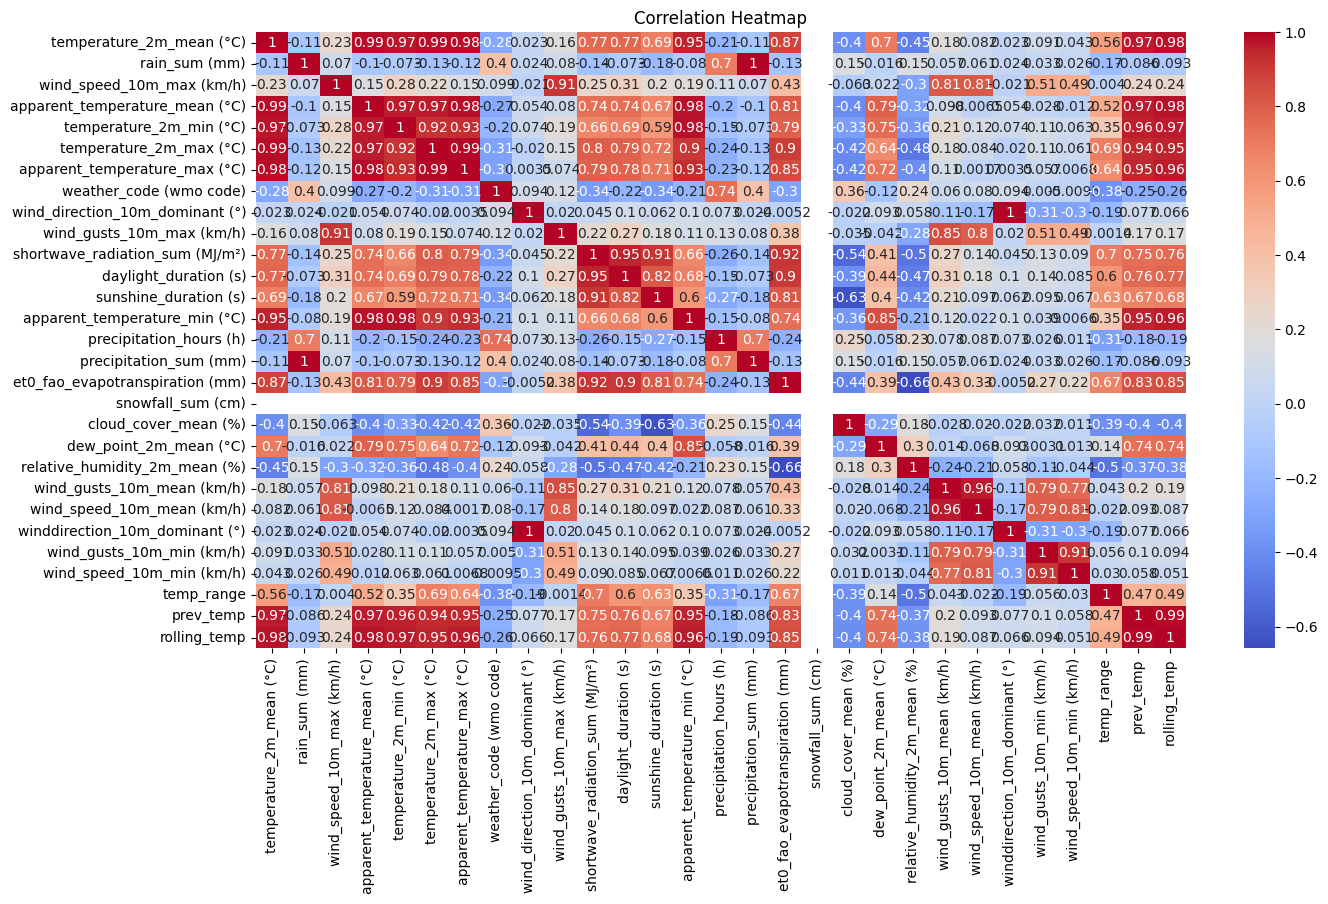

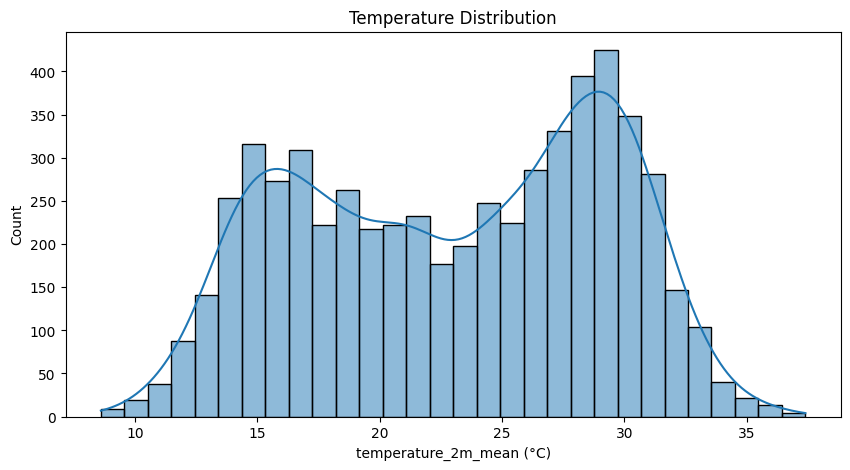

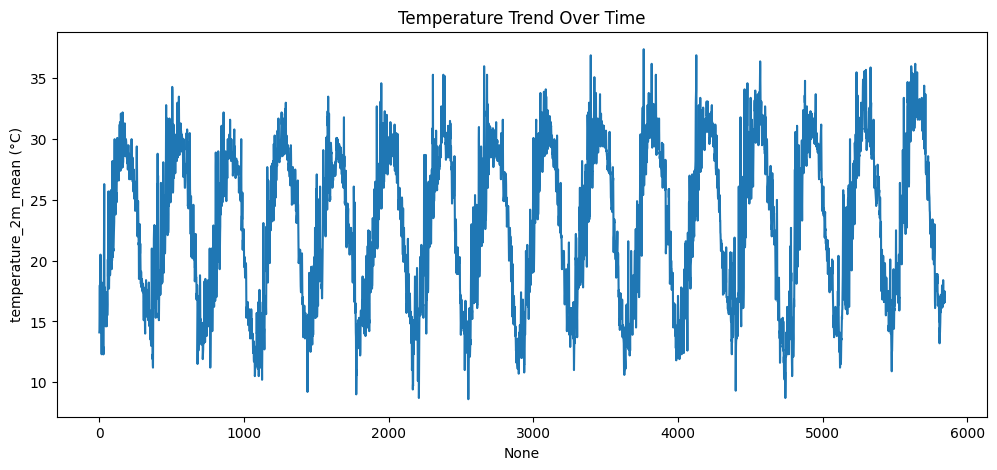

In [7]:
# Cell 5: Visualization
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['temperature_2m_mean (°C)'], bins=30, kde=True)
plt.title("Temperature Distribution")
plt.show()

plt.figure(figsize=(12,5))
sns.lineplot(data=df, y="temperature_2m_mean (°C)", x=df.index)
plt.title("Temperature Trend Over Time")
plt.show()

In [6]:
# Cell 6: Train-Test Split
features = [
    'apparent_temperature_mean (°C)','et0_fao_evapotranspiration (mm)',
    'daylight_duration (s)','shortwave_radiation_sum (MJ/m²)',
    'dew_point_2m_mean (°C)','sunshine_duration (s)',
    'temp_range','prev_temp','rolling_temp'
]

X = df[features]
y = df['temperature_2m_mean (°C)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Cell 7: Model Comparison
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([name, mse, r2])

results_df = pd.DataFrame(results, columns=["Model", "MSE", "R²"])
results_df

,Model,MSE,R²
0,Linear Regression,0.072242,0.998096
1,Random Forest,0.105954,0.997208
2,XGBoost,0.055425,0.998540


In [9]:
# Cell 8: Cross Validation
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
    print(f"{name}: Mean CV R² = {scores.mean():.3f}")

Linear Regression: Mean CV R² = 0.998
Random Forest: Mean CV R² = 0.997
XGBoost: Mean CV R² = 0.998


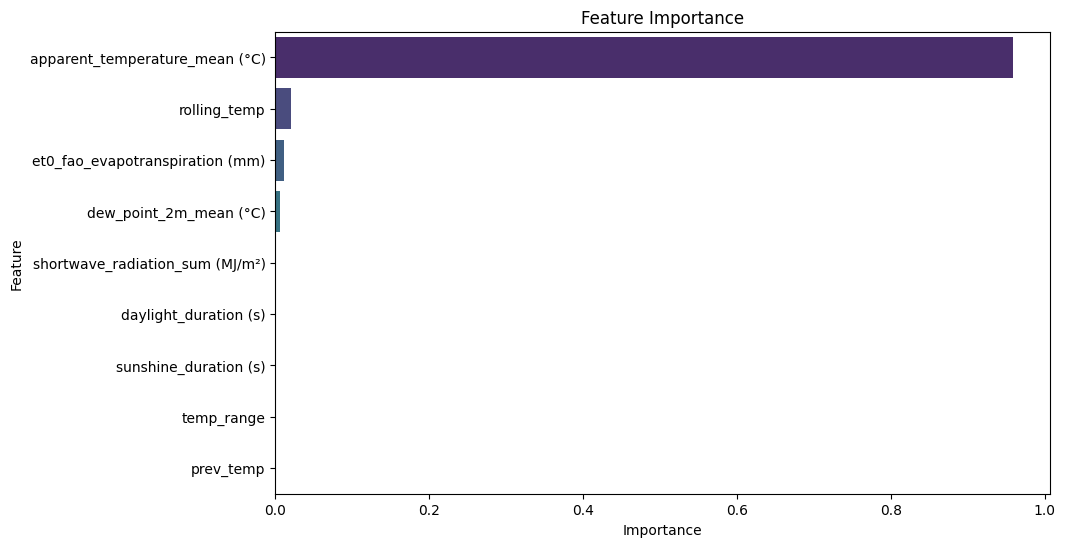

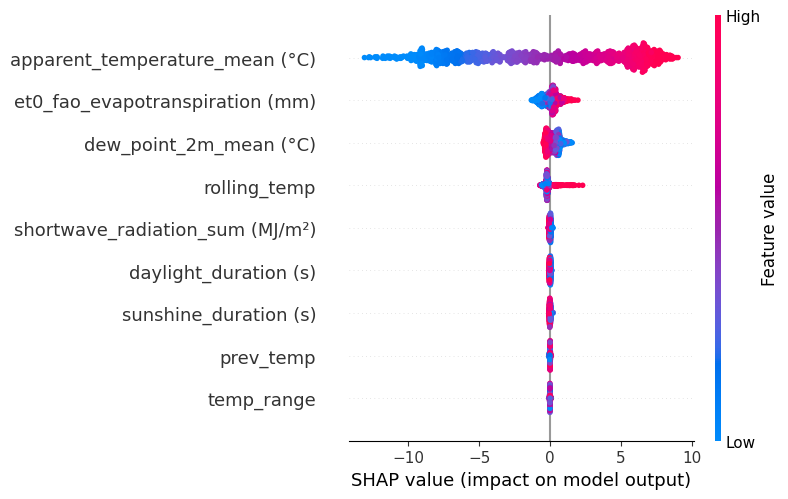

In [12]:
# Cell 9: Feature Importance& Explainability
best_model = models["Random Forest"]  # Change if needed
best_model.fit(X_train_scaled, y_train)

# Feature Importance
importances = best_model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x="Importance", y="Feature", hue="Feature", dodge=False, legend=False, palette="viridis")
plt.title("Feature Importance")
plt.show()

# SHAP (Explainability)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=features)

In [18]:
import joblib

joblib.dump(best_model, "BestModel.pkl")
joblib.dump(scaler, "Scaler.pkl")

print("Model & Scaler saved successfully!")

Model & Scaler saved successfully!


               Model       MSE  R² Score
0  Linear Regression  0.072242  0.998096
1      Random Forest  0.105954  0.997208
2            XGBoost  0.055425  0.998540


/tmp/ipython-input-3588182714.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="R² Score", palette="mako")


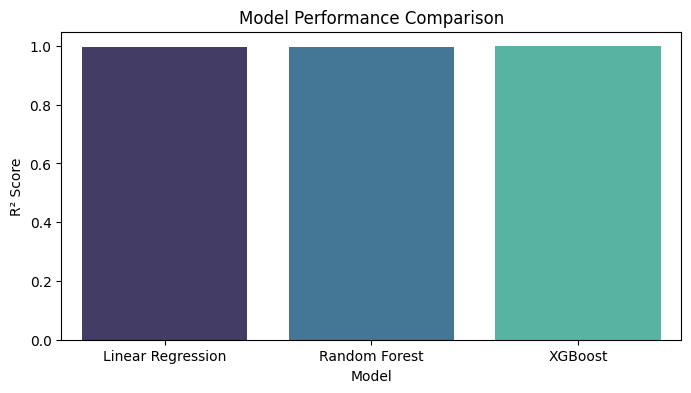

In [14]:
# Cell 11: Model Comparison Table
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append([name, mse, r2])

results_df = pd.DataFrame(results, columns=["Model", "MSE", "R² Score"])
print(results_df)

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="R² Score", palette="mako")
plt.title("Model Performance Comparison")
plt.show()

In [15]:
# Cell 12: Save & Load Best Model
best_model = models["Random Forest"]  # Or choose the best from results_df
best_model.fit(X_train_scaled, y_train)

joblib.dump(best_model, "best_model.pkl")
print("Model saved successfully!")

# Load again
loaded_model = joblib.load("best_model.pkl")
sample_pred = loaded_model.predict(X_test_scaled[:5])
print("Sample predictions:", sample_pred)

Model saved successfully!
Sample predictions: [30.288 32.673 27.627 16.262 13.363]


In [16]:
# Cell 13: Prediction Function
def predict_temperature(input_data):
    input_scaled = scaler.transform([input_data])
    prediction = loaded_model.predict(input_scaled)
    return prediction[0]

# Example:
example = X_test.iloc[0].values
print("Example input:", example)
print("Predicted temperature:", predict_temperature(example))

Example input: [3.18000000e+01 5.30000000e+00 4.63321000e+04 1.37800000e+01
 1.75000000e+01 2.19333500e+04 9.90000000e+00 3.30000000e+01
 3.23666667e+01]
Predicted temperature: 30.287999999999997


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
